## 1. 基于MNIST数据集的PyTorch神经网络训练

与numpy类似，PyTorch也使用一种独特的变量存储数字，即**PyTorch张量**，通过`torch.tensor()`创建，它有一个额外的可选参数`requires_grad`，

当`requires_grad=True`时：
+ PyTorch会追踪对该张量的所有操作（构建计算图）
+ 调用`.backward()`时，会自动计算该张量的梯度
+ 梯度会保存在`.grad`属性中

In [2]:
# 导入torch模块
import torch

# 创建简单的pytorch张量示例
x = torch.tensor(3.5, requires_grad=True)
y = (x-1)*(x-2)*(x-3)

# 计算梯度
y.backward()
x.grad

tensor(5.7500)

#### 计算图

以变量 $x,y,z$ 为例，当 $y$ 以 $x$ 的形式定义，而 $z$ 以 $y$ 的形式定义时，PyTorch便将这些张量连成一幅图，以展示这些张量是如何连接的，这幅图就叫做**计算图**。

以 $y=x^2,\ z=2y+3$ 为例，计算图看起来差不多是下面这个样子：

 ![计算图](figures/computation_graph_1.png)

 此外，图中还增加了几个反向箭头，表示 $z$ 如何随着 $y$ 变化， $y$ 如何随着 $x$ 变化，也就是**梯度**，梯度在训练过程中可以用来更新神经网络。求梯度的过程有PyTorch完成，无须我们自己手动计算。


In [3]:
# 创建包含x,y和z的计算图
x = torch.tensor(3.5, requires_grad=True)
y = x*x
z = 2*y + 3

# 计算梯度
z.backward()
x.grad

# 注意：此时若要求z关于y的梯度，不能使用y.grad
# 因为张量y并没有设置requires_grad=True，所以在计算时不会保留y的梯度
# 此时可以设置y.retain_grad()(在y的定义后)

tensor(14.)

在介绍完这样三个变量简单的连接之后，我们进一步再来看一个稍稍复杂的例子，即节点有多个进入的链接时：

![计算图2](figures/computation_graph_2.png)

这些节点之间的关系是：
$$
\begin{aligned}
x &= 2a+3b\\
y &= 5a^2+3b^3\\
z &= 2x+3y

\end{aligned}
$$

In [4]:
# 构建包含x,y和z的计算图
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)
x = 2*a + 3*b
y = 5*a**2 + 3*b**3
z = 2*x + 3*y

# 计算梯度
z.backward()
a.grad

# 它是计算出了两条路径上的梯度然后将每条路径上的梯度都加了起来，其实也就是求导的链式法则
# 但这种相加的操作在有时会带来一定的困扰，因为它不会自动将梯度归零
# 若不手动将梯度归零，在后面在进行a的梯度计算时，会在前面梯度的基础上做加法
# 如我再在后面进行操作
# x = 2*a + 3*b
# y = 5*a**2 + 3*b**3
# z = 2*x + 3*y
# z.backward()
# a.grad  # 其结果将是64+64=128

tensor(64.)

#### MNIST数据集

数据我将其放在了data文件夹中，训练集与测试集的样本量分别是 6 万 与 1 万，大小是 $28\times 28$像素的单色图像，每个像素的值在 $0\sim 255$的整数数值。MNIST数据集常被应用于比较机器学习算法的性能，故数据集的具体情况就不再赘叙。

在此处我们使用**pandas库**用于加载和查看数据。

`pandas.read_csv()`的输出对象类型是 pandas DataFrame，是一个与numpy数组类似的数据结构，具有许多附加功能，包括可为列和行命名，以及提供便利函数对数据求和和过滤等。

数据mnist_train.csv和mnist_test.csv自行下载并放置data子文件夹

In [5]:
# 导入pandas库，用于读取csv文件
import pandas

df = pandas.read_csv('data/mnist_train.csv', header=None)
df.head() # 查看DataFrame的前5行（默认）

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df.info()  # 查看DataFrame的一些基本信息

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 359.3 MB


+ `DataFrame.iloc[]`：Pandas 中基于整数位置（位置索引）进行行/列切片
+ `DataFrame.loc[]`：基于标签索引
+ `.to_numpy()`： Pandas Series/DataFrame转换为Numpy数组
+ `.numpy()`：PyTorch Tensor转换为Numpy数组，需满足 CPU + 无梯度

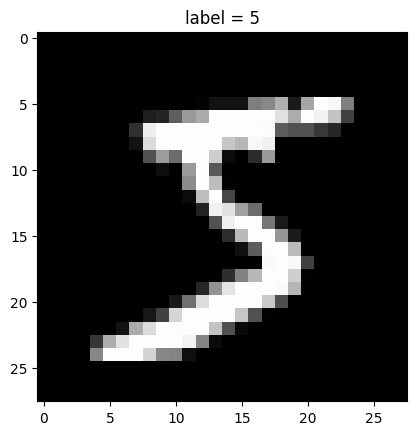

In [7]:
# 取数据集中的一个样本看看是什么样的图像
# 导入matplotlib库用于绘图
from sqlite3 import Row
import matplotlib.pyplot as plt

row = 0
data = df.iloc[row] # 根据数值按行索引，即取第row+1个样本

# 第一个值是标签
label = data[0]
img = data[1:].to_numpy().reshape(28,28)
plt.title("label = " + str(label))
plt.imshow(img, interpolation='none', cmap='gray')
plt.show()

#### 神经网络

因为只是简单的示例，所以我们在这只考虑一层隐藏层，即除了输入层与输出层外，中间层考虑一个大小为 200 的隐藏层，即神经网络的结构如下：

![神经网络结构](figures/NN_1.png)

网络中任何一层的所有节点，都会连接到下一层中的所有节点，这种网络层被称为**全连接层**（fully connected layer）

隐藏层和输出层的**激活函数**在此我们考虑S型逻辑函数Sigmoid，接下来我们就可以来进行神经网络的构建了。

In [8]:
import torch
import torch.nn as nn

+ `__init__(self)`：**构造函数**
+ `super().__init__()`：调用父类的构造函数
+ `nn.Sequential()`：按顺序堆叠神经网络层的容器，数据会自动依次通过每一层，无需手动编写 forward() 方法（适合简单线性结构），层之间自动连接（前一层的输出 是 后一层的输入）
+ `nn.Linear()`：全连接层（线性变换），包含节点之间链接的权重，即模型参数，会在训练开始前给出初始化参数，并且在训练时会被更新
+ `nn.Sigmoid()`：将S型逻辑激活函数应用于前一个函数的输出
+ `nn.MSELoss()`：均方误差
+ `torch.optim.SGD()`：使用随机梯度下降算法，学习率设置为0.01
+ `self.optimiser.zero_grad()`：将优化器所管理的所有参数的梯度（.grad 属性）清零
+ `self.optimiser.step()`：根据当前计算出的梯度更新模型参数

In [ ]:
# 构建神经网络类
class Classifier(nn.Module):

    def __init__(self):
        # 初始化pytorch父类
        super().__init__()

        # 定义神经网络层（输出PyTorch张量）
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.Sigmoid(),
            nn.Linear(200, 10),
            nn.Sigmoid()
        )

        # 创建损失函数
        self.loss_function = nn.MSELoss()

        # 创建优化器（简单梯度下降）
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # 记录训练进展的计数器和列表
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        # 直接运行模型
        return self.model(inputs)

    def train(self, inputs, targets):
        # 计算网络的输出值
        outputs = self.forward(inputs)
        # 计算损失值
        loss = self.loss_function(outputs, targets)
        # 梯度归零，反向传播，并更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        # 每隔10个训练样本增加一次计数器的值，并将损失值添加进列表末尾
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1,
                marker='.', grid=True, yticks=(0,0.25,0.5))

尝试以PyTorch的方式加载和使用数据，PyTorch使用torch.utils.data.DataLoader实现了一些实用的功能，比如自动打乱数据顺序、多个进程并行加载、分批处理等，需要先将数据载入一个torch.utils.data.Dataset对象。


为了简单起见，我们暂时不需要打乱数据顺序或分批处理。但是，我们仍会使用torch.utils.data.Dataset类，以积累使用PyTorch的经验。

In [10]:
from torch.utils.data import Dataset

+ `__len__()`：获取数据集中的数据量
+ `__getitem__()`：能够能够索引获取数据集内的数据
+ label表示数据的标签
+ image_values表示图像数据张量（ $0\sim 1$ ）
+ target表示label的one-hot编码（独热编码）
+ `plot_image(index)`：根据索引，绘制相应的数据图像

In [11]:
# 创建一个MnistDataset类
class MnistDataset(Dataset):

    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        # 目标图像（标签）
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0 # type: ignore

        # 图像数据，取值范围为0~255,标准化为0~1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].to_numpy()) / 255.0

        # 返回标签、图像数据张量以及目标张量
        return label,image_values,target

    def plot_image(self,index):
        arr = self.data_df.iloc[index,1:].to_numpy().reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(arr, interpolation='none', cmap='gray')

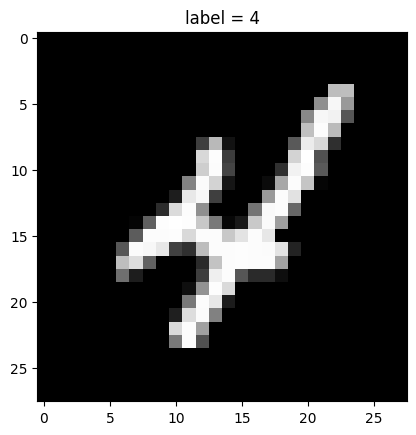

In [14]:
mnist_dataset = MnistDataset('data/mnist_train.csv')
mnist_dataset.plot_image(9)
# mnist_dataset[100]

#### 神经网络的训练

+ `%%time`：Jupyter Notebook / JupyterLab / IPython 中的一个魔法命令（Magic Command），用于测量并输出单个单元格的执行时间
+ CPU times：所有 CPU 核心上消耗的计算时间总和（user + sys）
+ Wall time（挂钟时间）：真实经过的时间（端到端耗时）
+ 注意：当任务能并行利用多个 CPU 核时，CPU time 通常大于 Wall time

training epoch 1 of 3
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
c

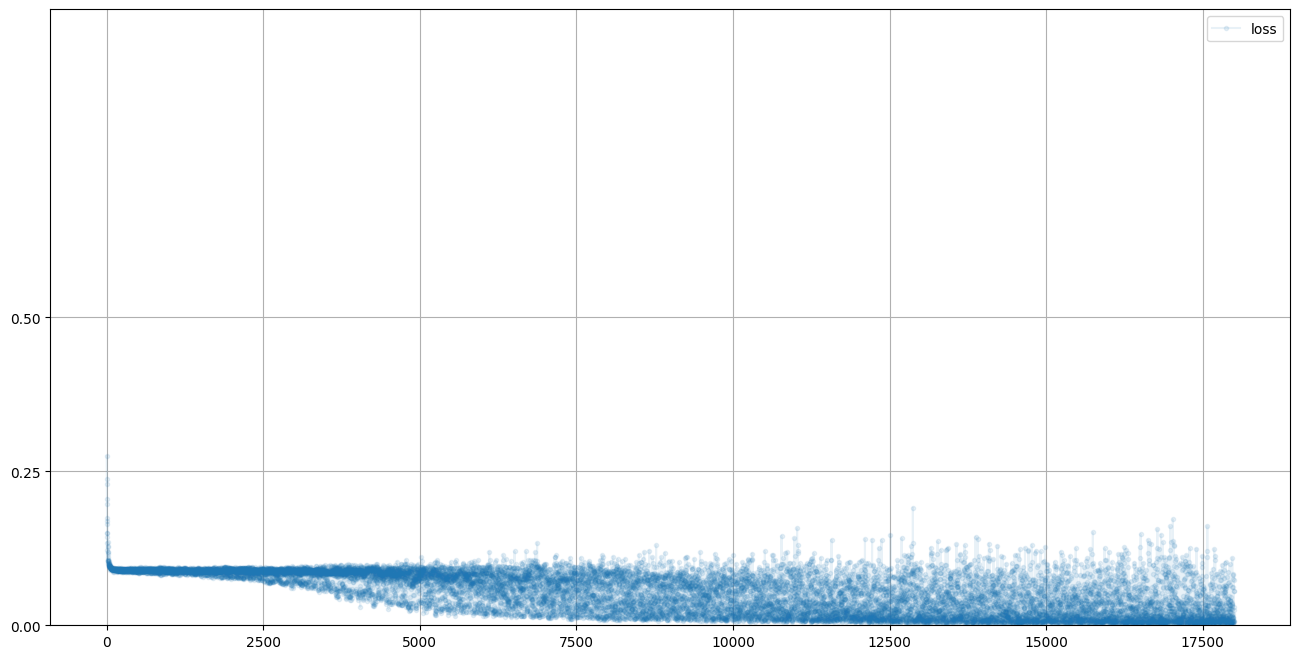

In [15]:
%%time
# 创建神经网络
C = Classifier()

# 在MNITST数据集训练神经网络
epochs = 3
for i in range(epochs):
    print('training epoch', i+1, 'of', epochs)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        C.train(image_data_tensor, target_tensor)
### 绘制损失图
C.plot_progress()

从上图可见，损失值从一开始迅速下降到大约0.1，并在训练过程中越来越慢地接近0。同时，噪声也非常多。

损失值的下降意味着网络分类图像的能力越来越好。损失图很实用，它让我们了解到网络训练是否有效。它也告诉我们训练是平稳的，还是不稳定的、混乱的。

#### 查询神经网络

现在我们有了一个训练后的网络，可以进行图像分类了。我们将切换到包含10 000幅图像的MNIST测试数据集。这些是我们的神经网络从来没看到过的图像。

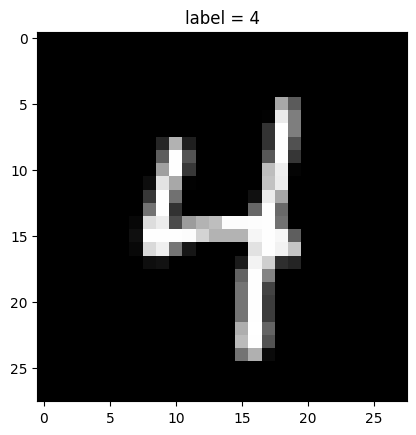

In [16]:
# 加载MNIST测试数据
mnist_test_dataset = MnistDataset('data/mnist_test.csv')

# 查看第20幅图像，及神经网络的分类情况
record = 19
mnist_test_dataset.plot_image(record)

+ `.detach()`：forward()的输出结果是带梯度计算的PyTorch张量，detach()切断张量与计算图的连接，返回一个不参与梯度计算的新张量
+ `.numpy()`：将 PyTorch 张量（CPU 上，无梯度计算）转换为 NumPy 数组

<Axes: >

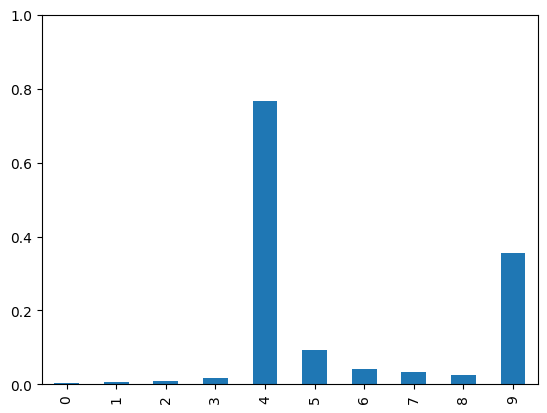

In [17]:
image_data = mnist_test_dataset[record][1]
# 调用训练后的神经网络
output = C.forward(image_data)
# 绘制输出张量
pandas.DataFrame(output.detach().numpy()).plot(kind='bar',legend=False,ylim=(0,1))

10条柱形分别对应10个神经网络输出节点的值。最大值对应节点4，也就是说我们的网络认为图像是4，即神经网络对测试图像的分类是正确的

可测试其他样本，如第34幅是分类错误的

#### 利用测试机评估该神经网络的性能

In [18]:
# 测试用训练数据训练后的网络
score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test_dataset:
    answer = C.forward(image_data_tensor).detach().numpy()
    if (answer.argmax() == label):
        score += 1
    items += 1
print(score, items, score/items)

8636 10000 0.8636


可以看到，模型的最后分数约为87%。考虑到这是一个很简单的神经网络，这个分数也不算太差

#### 改良方法

##### 1. 损失函数

+ 二分类问题：二元交叉熵损失函数：`nn.BCELoss()`，它同时惩罚置信度（confidence）高的错误输出和置信值低的正确输出

![二元交叉熵损失](figures/BCE_loss.png)

测试集上的结果：9025 10000 0.9025

+ 多分类问题：交叉熵损失函数：`nn.CrossEntropyLoss()`（去掉最后输出层的Sigmoid激活函数，且target不用one-hot编码表示）

![交叉熵损失](figures/CrossEntropy_loss.png)

测试集上的结果：9552 10000 0.9552

可以看到，损失值的确在下降，不过下降的速度比MSELoss()慢。损失值的噪声也更大，以至于在训练的后期偶尔也有较高的损失值出现。虽然损失图看起来比之前要糟糕一些，但是在训练结束时，大部分损失值都更低，性能得分也更高。

##### 2. 激活函数

S型逻辑函数在神经网络发展的早期被广泛使用，因为它的形状看起来比较符合自然界中的实际情况。科学家们普遍认为，动物的神经元之间在传递信号时，也存在一个类似的阈值。此外，也因为在数学上它的梯度较容易计算。

然而，它具有一些缺点。最主要的一个缺点是，在输入值变大时，梯度会变得非常小甚至消失。这意味着，在训练神经网络时，如果发生**饱和**（saturation），我们无法通过梯度来更新链接权重。

![Sigmoid曲线](figures/Sigmoid.png)

其他可选的激活函数有许多。一个简单的解决方案是使用直线作为激活函数，而直线的固定梯度是永远不会消失的。

![ReLU曲线](figures/ReLU.png)

这个激活函数被称为**线性整流函数**（rectified linearunit）, 在PyTorch中被定义为**ReLU()**函数。

实际上，如果所有负值的斜率都是0，小于0的输入部分同样存在梯度消失的问题。一个简单的改良是在函数的左半边增加一个小梯度，这被称为**带泄漏线性整流函数**（Leaky ReLU）。

![Leaky ReLU曲线](figures/LReLU.png)

将损失函数重置为MSELoss()，并将激活函数改为LeakyReLU（0.02），其中0.02是函数左半边的梯度：

![LeakyReLU](figures/LeReLU_loss.png)

测试集上的结果：9697 10000 0.9697

从图中可见，损失值从一开始就迅速下降到接近于0。即使在训练初期，平均损失值就很低，同时噪声也较少。


#### 3. 改良方法

之前我们使用的是相对简单的随机梯度下降法，它方法简单，对于计算性能的要求较低，但它有两个缺点：
+ 会陷入损失函数的局部最小值 （local minima）
+ 对所有可学习的参数都使用单一的学习率

可替代的方案有许多，其中最常见的是**Adam**。它直接解决了以上两个缺点。首先，它利用动量 （momentum）的概念，减少陷入局部最小值的可能性。我们可以想象一下，一个沉重的球如何利用动量滚过一个小坑。同时，它对每个可学习参数使用单独的学习率，这些学习率随着每个参数在训练期间的变化而改变。

我们重新设置代码，保留MSELoss()和S型激活函数，只将优化器从SGD改为Adam：

`self.optimiser = torch.optim.Adam(self.parameters())`

![Adam](figures/Adam_loss.png)

在测试集上的结果：9715 10000 0.9715

#### 4. 标准化

神经网络中的权重和信号（向网络输入的数据）的取值范围都很大。之前，我们看到较大的输入值会导致饱和，使学习变得困难。

大量研究表明，减少神经网络中参数和信号的取值范围，以及将均值转换为0，是有好处的。我们称这种方法为**标准化**；一种常见的做法是，在信号进入一个神经网络层之前将它标准
化。

把代码重置回使用MSELoss、S型激活函数以及SGD优化器。现在，在网络信号输入最终层之前使用LayerNorm（200），将它们标准化

![normality](figures/norm_loss.png)

在测试集上的结果：9109 10000 0.9109

可以看出，损失值下降的速率要高于原始网络。如果我们考虑噪声在图中的密度，而不只是高度，则损失值的噪声也较少。

#### 5. 整合以上方法

把以上的改良方法整合到一起，包括BCE损失、Leaky ReLU激活函数、Adam优化器以及分层标准化。由于BCE只能处理0～1的值，而Leaky ReLU则有可能输出范围之外的值，我们在最终层之后保留一个S型函数，但是在隐藏层之后使用LeakyReLU。

![summary1](figures/summary_loss1.png)

测试集上的结果：9727 10000 0.9727

In [ ]:
# 以下是测试代码

In [5]:
# 导入库
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import pandas
import matplotlib.pyplot as plt

In [ ]:
# 构建神经网络类
class Classifier(nn.Module):

    def __init__(self):
        # 初始化pytorch父类
        super().__init__()

        # 定义神经网络层
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 10),

        )

        # 创建损失函数
        self.loss_function = nn.CrossEntropyLoss()
        # self.loss_function = nn.MSELoss()
        # self.loss_function = nn.BCELoss()

        # 创建优化器（简单梯度下降）
        # self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        self.optimiser = torch.optim.Adam(self.parameters())

        # 记录训练进展的计数器和列表
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        # 直接运行模型
        return self.model(inputs)

    def train(self, inputs, targets):
        # 计算网络的输出值
        outputs = self.forward(inputs)
        # 计算损失值
        loss = self.loss_function(outputs, targets)
        # 梯度归零，反向传播，并更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        # 每隔10个训练样本增加一次计数器的值，并将损失值添加进列表末尾
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1,
                marker='.', grid=True, yticks=(0,0.25,0.5))



# 创建一个MnistDataset类
class MnistDataset(Dataset):

    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        # 目标图像（标签）
        label = self.data_df.iloc[index,0]

        # 图像数据，取值范围为0~255,标准化为0~1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].to_numpy()) / 255.0

        # 返回标签、图像数据张量以及目标张量
        return label,image_values

    def plot_image(self,index):
        arr = self.data_df.iloc[index,1:].to_numpy().reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(arr, interpolation='none', cmap='gray')


training epoch 1 of 3
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
c

In [ ]:
%%time

### 训练数据集
mnist_dataset = MnistDataset('data/mnist_train.csv')

# 创建神经网络
C1 = Classifier()

# 在MNITST数据集训练神经网络
epochs = 3
for i in range(epochs):
    print('training epoch', i+1, 'of', epochs)
    for label, image_data_tensor in mnist_dataset:
        C1.train(image_data_tensor,torch.tensor(label))

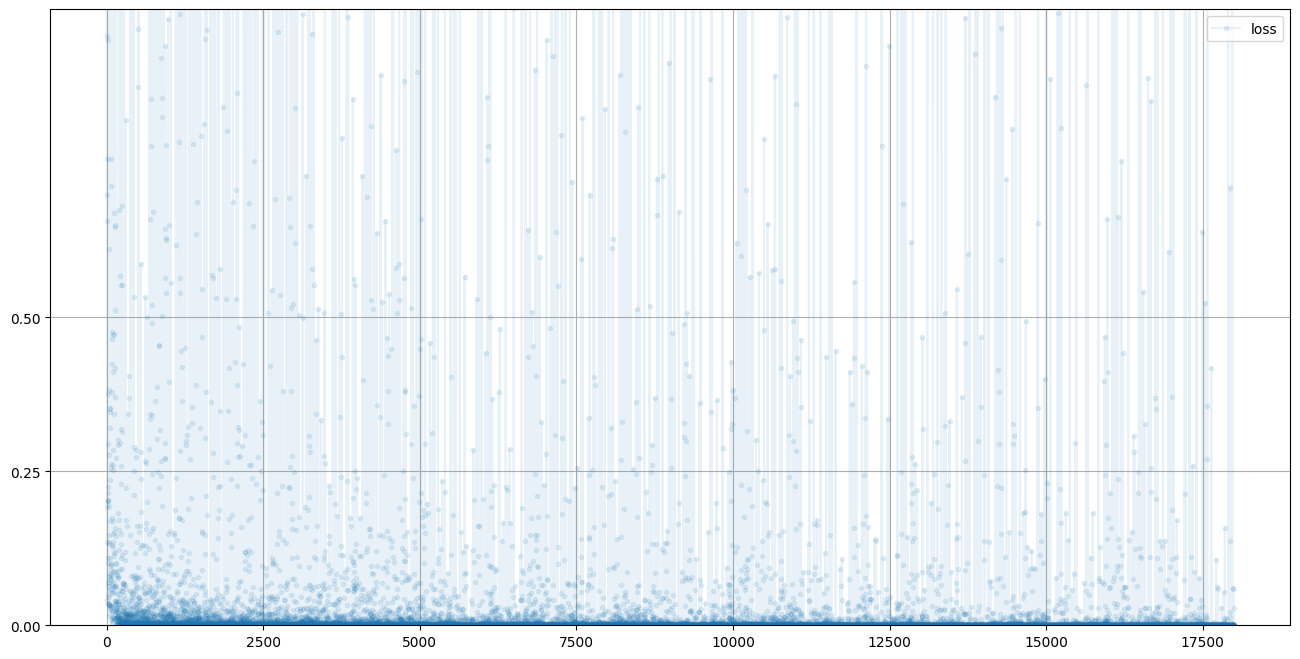

In [ ]:
### 绘制损失图
C1.plot_progress()

In [ ]:
mnist_test_dataset = MnistDataset('data/mnist_test.csv')

### 测试集上的表现
score = 0
items = 0

for label, image_data_tensor in mnist_test_dataset:
    answer = C1.forward(image_data_tensor).detach().numpy()
    if (answer.argmax() == label):
        score += 1
    items += 1
print(score, items, score/items)

9655 10000 0.9655


In [ ]:
# 导入库
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import pandas
import matplotlib.pyplot as plt

In [59]:
# 构建神经网络类
class Classifier(nn.Module):

    def __init__(self):
        # 初始化pytorch父类
        super().__init__()

        # 定义神经网络层
        self.model = nn.Sequential(
            nn.Linear(10, 200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200, 784),
            nn.Sigmoid()
        )

        # 创建损失函数
        # self.loss_function = nn.CrossEntropyLoss()
        self.loss_function = nn.MSELoss()
        # self.loss_function = nn.BCELoss()

        # 创建优化器（简单梯度下降）
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        # self.optimiser = torch.optim.Adam(self.parameters())

        # 记录训练进展的计数器和列表
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        # 直接运行模型
        return self.model(inputs)

    def train(self, inputs, targets):
        # 计算网络的输出值
        outputs = self.forward(inputs)
        # 计算损失值
        loss = self.loss_function(outputs, targets)
        # 梯度归零，反向传播，并更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        # 每隔10个训练样本增加一次计数器的值，并将损失值添加进列表末尾
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0,0.25), figsize=(16,8), alpha=0.1,
                marker='.', grid=True, yticks=(0,0.05,0.1))



# 创建一个MnistDataset类
class MnistDataset(Dataset):

    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        # 目标图像（标签）
        label = self.data_df.iloc[index,0]
        label = F.one_hot(torch.tensor(label), num_classes=10).float() / 9.0

        # 图像数据，取值范围为0~255,标准化为0~1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].to_numpy()) / 255.0

        # 返回标签、图像数据张量
        return label,image_values

    def plot_image(self,index):
        arr = self.data_df.iloc[index,1:].to_numpy().reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(arr, interpolation='none', cmap='gray')


In [60]:
%%time

### 训练数据集
mnist_dataset = MnistDataset('data/mnist_train.csv')

# 创建神经网络
C1 = Classifier()

# 在MNITST数据集训练神经网络
epochs = 3
for i in range(epochs):
    print('training epoch', i+1, 'of', epochs)
    for label, image_data_tensor in mnist_dataset:
        C1.train(label,image_data_tensor)

training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: total: 16min 1s
Wall time: 3min 24s


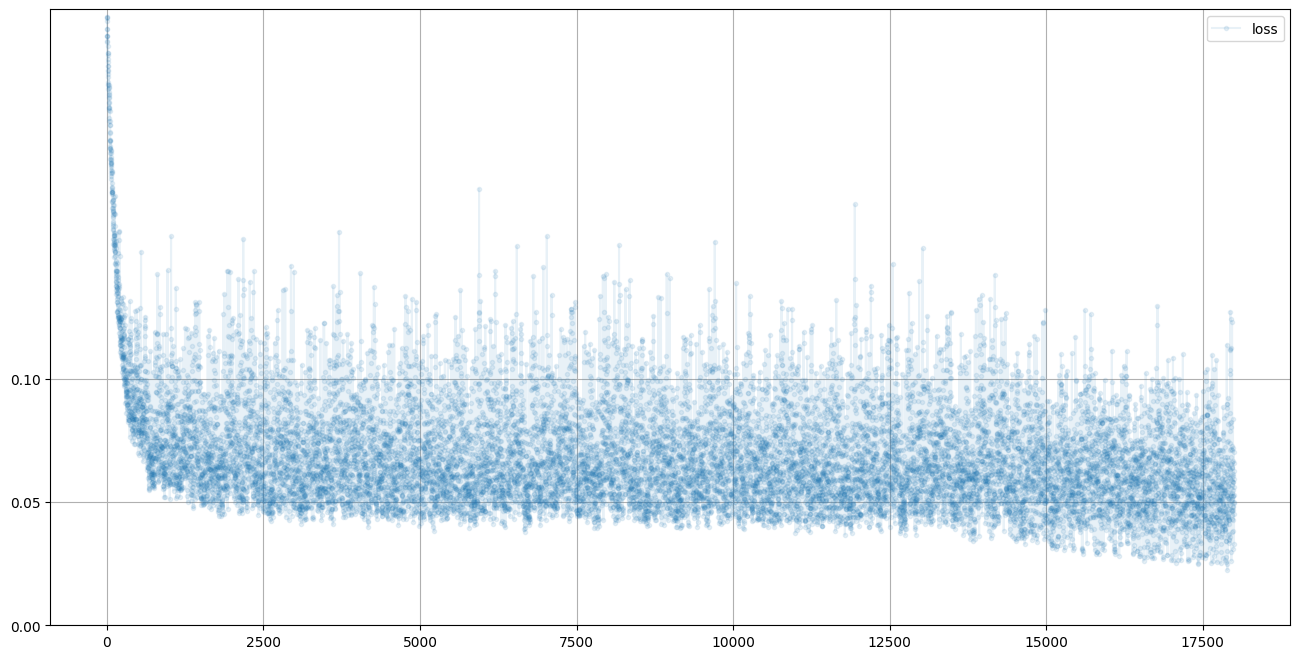

In [61]:
### 绘制损失图
C1.plot_progress()
# C1.progress

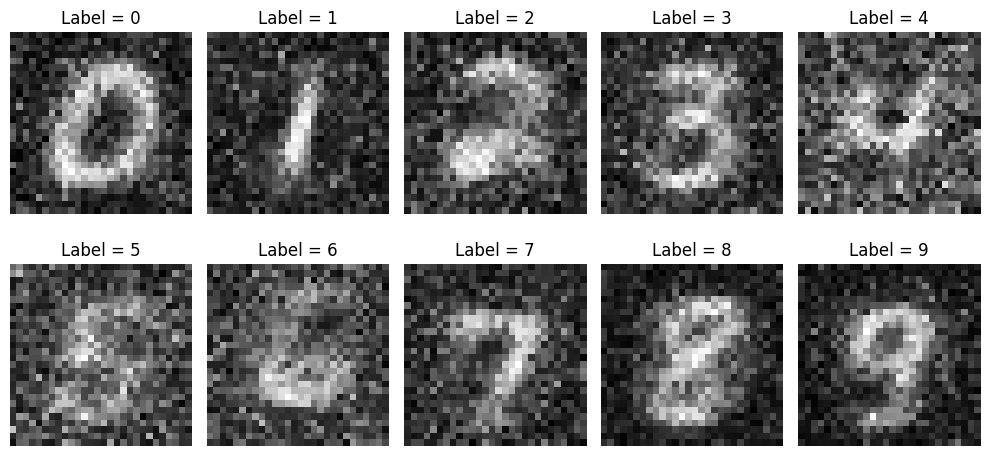

In [62]:
# 创建一个 2 行 5 列的子图
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for digit in range(10):
    # 创建标签为 digit 的 one-hot 向量
    label = F.one_hot(torch.tensor([digit]), num_classes=10).float()  # shape: [1, 10]

    # 前向传播生成图像
    output = C1.forward(label)  # shape: [1, 784]

    # 转为 numpy 并 reshape 成 28x28
    generated_image = output.detach().numpy().reshape(28, 28)

    # 计算当前数字在子图中的位置
    row = digit // 5  # 第0行：0-4，第1行：5-9
    col = digit % 5   # 列：0,1,2,3,4

    # 绘图
    axes[row, col].imshow(generated_image, cmap='gray')
    axes[row, col].set_title(f"Label = {digit}")
    axes[row, col].axis('off')  # 隐藏坐标轴

# 调整子图间距
plt.tight_layout()
plt.show()

In [ ]:
pandas.DataFrame(C1.progress, columns=['sgd_loss']).to_csv('data/loss_generative.csv', index=False)

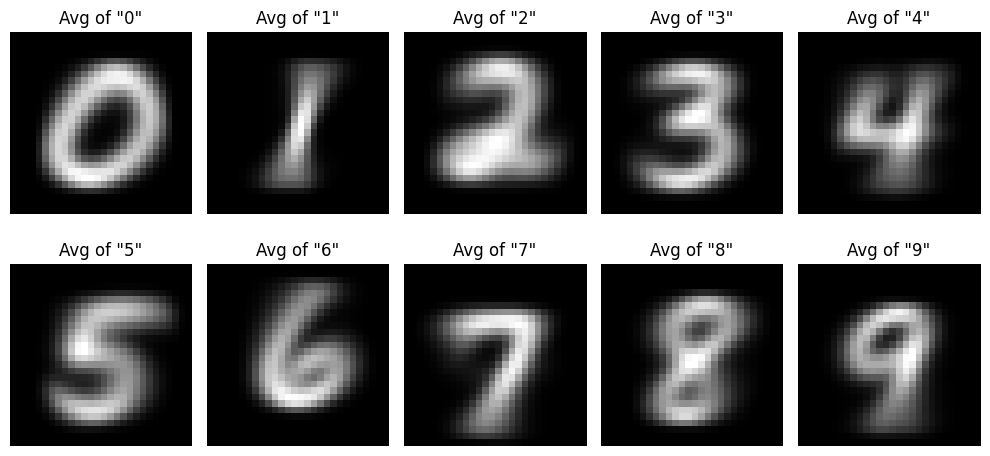

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取训练数据
df = pd.read_csv('data/mnist_train.csv', header=None)

# 初始化一个字典，用于存储每个数字的图像列表
digit_images = {i: [] for i in range(10)}

# 遍历每一行，按标签分组收集图像
for idx in range(len(df)):
    row = df.iloc[idx]
    label = int(row[0])
    image = row[1:].values.astype(np.float32) / 255.0  # 归一化到 [0,1]
    digit_images[label].append(image)

# 计算每个数字的平均图像
average_images = {}
for digit in range(10):
    images = np.array(digit_images[digit])  # shape: [N, 784]
    avg_image = images.mean(axis=0)        # shape: [784]
    average_images[digit] = avg_image.reshape(28, 28)  # reshape to [28, 28]

# 绘制 2 行 5 列的平均图像
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for digit in range(10):
    row = digit // 5
    col = digit % 5
    axes[row, col].imshow(average_images[digit], cmap='gray')
    axes[row, col].set_title(f'Avg of "{digit}"')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [1]:
import pandas

# 读取训练数据（第一列是标签）
df = pandas.read_csv('data/mnist_train.csv', header=None)

# 统计第0列（标签列）中每个数字的出现次数
label_counts = df[0].value_counts().sort_index()

# 打印结果
print("MNIST 训练集中各标签的样本数量：")
print(label_counts)


MNIST 训练集中各标签的样本数量：
0
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: count, dtype: int64


In [2]:
df_digit_0 = df[df[0] == 0]
# 保存为新的 CSV 文件
df_digit_0.to_csv('data/mnist_train_digit_0.csv', index=False, header=False)

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NoiseToDigit0(nn.Module):
    def __init__(self, noise_dim=10, img_dim=784):
        super(NoiseToDigit0, self).__init__()
        self.noise_dim = noise_dim
        self.img_dim = img_dim

        # 定义生成器网络（从噪声到图像）
        self.generator = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()  # 输出在 [0,1]，匹配图像像素范围
        )

    def forward(self, noise):
        return self.generator(noise)

In [23]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class Digit0Dataset(Dataset):
    def __init__(self, csv_file):
        self.data_df = pd.read_csv(csv_file, header=None)
        # 提取图像数据（第1列到第784列），归一化到 [0,1]
        self.images = torch.FloatTensor(self.data_df.iloc[:, 1:].values) / 255.0

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        # 返回对应的数字 0 图像
        return self.images[idx]

# 加载数据
digit0_dataset = Digit0Dataset('data/mnist_train_digit_0.csv')
dataloader = DataLoader(digit0_dataset, batch_size=64, shuffle=True)

In [26]:
# 初始化模型和优化器
model = NoiseToDigit0(noise_dim=10, img_dim=784)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
criterion = nn.MSELoss()  # 也可以用 L1 Loss

# 训练参数
epochs = 1000
noise_dim = 10

for epoch in range(epochs):
    total_loss = 0
    for real_images in dataloader:
        batch_size = real_images.size(0)

        # 生成随机噪声
        noise = torch.randn(batch_size, noise_dim)

        # 前向传播：噪声 -> 生成图像
        fake_images = model(noise)

        # 计算损失（生成图像 vs 真实图像）
        loss = criterion(fake_images, real_images)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # 每 10 个 epoch 打印一次平均损失
    if (epoch + 1) % 10 == 0:
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [10/1000], Loss: 0.0641
Epoch [20/1000], Loss: 0.0639
Epoch [30/1000], Loss: 0.0638
Epoch [40/1000], Loss: 0.0638
Epoch [50/1000], Loss: 0.0638
Epoch [60/1000], Loss: 0.0638
Epoch [70/1000], Loss: 0.0638
Epoch [80/1000], Loss: 0.0637
Epoch [90/1000], Loss: 0.0637
Epoch [100/1000], Loss: 0.0637
Epoch [110/1000], Loss: 0.0637
Epoch [120/1000], Loss: 0.0637
Epoch [130/1000], Loss: 0.0638
Epoch [140/1000], Loss: 0.0637
Epoch [150/1000], Loss: 0.0637
Epoch [160/1000], Loss: 0.0637
Epoch [170/1000], Loss: 0.0637
Epoch [180/1000], Loss: 0.0637
Epoch [190/1000], Loss: 0.0637
Epoch [200/1000], Loss: 0.0637
Epoch [210/1000], Loss: 0.0637
Epoch [220/1000], Loss: 0.0637
Epoch [230/1000], Loss: 0.0637
Epoch [240/1000], Loss: 0.0637
Epoch [250/1000], Loss: 0.0637
Epoch [260/1000], Loss: 0.0637
Epoch [270/1000], Loss: 0.0637
Epoch [280/1000], Loss: 0.0637
Epoch [290/1000], Loss: 0.0637
Epoch [300/1000], Loss: 0.0637
Epoch [310/1000], Loss: 0.0637
Epoch [320/1000], Loss: 0.0637
Epoch [330/1000],

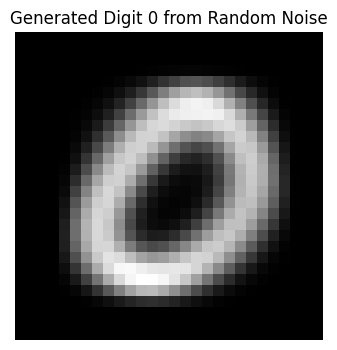

In [57]:
# 生成一张数字 0 图像
import matplotlib.pyplot as plt

model.eval()  # 切换到评估模式

# 生成一个随机噪声向量
noise = torch.FloatTensor([[1,2,3,4,5,6,7,8,9,10]])

# 生成图像
with torch.no_grad():  # 关闭梯度
    generated_image = model(noise).view(28, 28).numpy()

# 绘图
plt.figure(figsize=(4, 4))
plt.imshow(generated_image, cmap='gray')
plt.title("Generated Digit 0 from Random Noise")
plt.axis('off')
plt.show()